In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import datetime

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
file = "D:\Anshul\Code\IMD\Data\Shivajinagar\Shivajinagar Cleaned Data.csv"
df = pd.read_csv(file)
df.rename(columns = {'Unnamed: 0':'Timestamp'}, inplace = True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df

,Timestamp,RAIN_DAILY(mm),TEMP(C),DEW_POINT(C),RH(%),WIND_SPEED_10m(kt),SLP(hPa),MSLP(hPa),Day sin,Day cos,Year sin,Year cos
0,2020-01-01 02:15:00,0.0,11.9,11.5,98.0,0.0,950.7,1015.9,0.000000,1.000000,0.000000,1.000000
1,2020-01-01 02:30:00,0.0,12.4,12.0,98.0,0.0,951.0,1016.1,0.065403,0.997859,0.000179,1.000000
2,2020-01-01 02:45:00,0.0,13.7,13.3,98.0,1.0,951.2,1016.1,0.130526,0.991445,0.000358,1.000000
3,2020-01-01 03:00:00,0.0,15.0,14.3,96.0,1.0,951.5,1016.1,0.195090,0.980785,0.000538,1.000000
4,2020-01-01 03:15:00,0.0,16.7,13.8,83.0,1.0,951.9,1016.1,0.258819,0.965926,0.000717,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
146354,2024-07-12 04:00:00,0.0,26.8,24.6,88.0,4.0,943.0,1004.4,0.442289,0.896873,-0.179338,-0.983787
146355,2024-07-12 04:15:00,0.0,27.7,24.5,83.0,6.0,943.0,1004.2,0.500000,0.866025,-0.179515,-0.983755
146356,2024-07-12 04:30:00,0.0,27.5,24.3,83.0,5.0,943.0,1004.2,0.555570,0.831470,-0.179691,-0.983723
146357,2024-07-12 04:45:00,0.0,27.5,24.3,83.0,5.0,943.0,1004.2,0.608761,0.793353,-0.179867,-0.983691


### Building the model for a timeseries forecast

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Normalization
tf.__version__

'2.15.0'

In [6]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 1:8].values
seq_length = 4

ts_generator = TimeseriesGenerator(X, y, length=seq_length, batch_size=20)

In [7]:
normalizer = Normalization()
normalizer.adapt(X)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X.shape[1])),
    tf.keras.layers.TimeDistributed(normalizer),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(y.shape[1])  # Output shape should match the number of features
])
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['accuracy', tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
)
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 4, 11)             23        
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 4, 50)             12400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 7)                 357       
                                                                 
Total params: 32980 (128.83 KB)
Trainable params: 32957 (128.74 KB)
Non-trainable params: 23 (96.00 Byte)
_________________________________________________________________


In [8]:
history = model.fit(ts_generator, epochs=10, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2))

Epoch 1/10


7318/7318 [==============================] - 65s 8ms/step - loss: 180703.3594 - accuracy: 0.3286 - mean_squared_error: 180703.3594 - root_mean_squared_error: 425.0921 - mean_absolute_error: 230.9000
Epoch 2/10
7318/7318 [==============================] - 63s 9ms/step - loss: 58881.0039 - accuracy: 1.0000 - mean_squared_error: 58881.0039 - root_mean_squared_error: 242.6540 - mean_absolute_error: 131.4014
Epoch 3/10
7318/7318 [==============================] - 66s 9ms/step - loss: 7119.1709 - accuracy: 1.0000 - mean_squared_error: 7119.1709 - root_mean_squared_error: 84.3753 - mean_absolute_error: 43.2426
Epoch 4/10
7318/7318 [==============================] - 67s 9ms/step - loss: 237.8775 - accuracy: 1.0000 - mean_squared_error: 237.8775 - root_mean_squared_error: 15.4233 - mean_absolute_error: 6.5789
Epoch 5/10
7318/7318 [==============================] - 67s 9ms/step - loss: 222.6210 - accuracy: 1.0000 - mean_squared_error: 222.6210 - root_mean_squared_error: 14.9205 - me

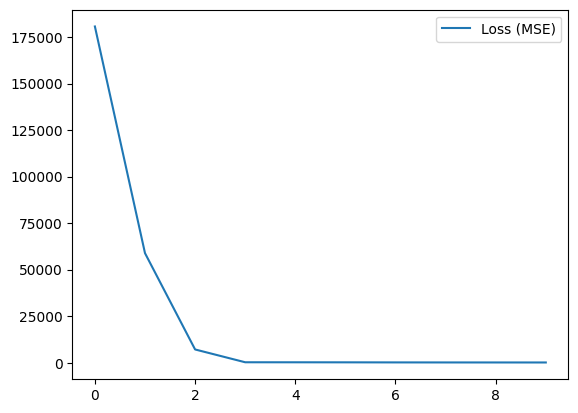

In [9]:
plt.plot(history.history['loss'], label='Loss (MSE)')
plt.legend()
plt.show()

In [10]:
model.save("D:\Anshul\Code\IMD\Forecast Model.h5")

In [19]:
predictions = pd.DataFrame(model.predict(ts_generator), columns=df.columns[1:8])
#predictions['Timestamp'] = pd.to_datetime(forecast_df['Timestamp'])
predictions.index = pd.to_datetime(df['Timestamp'].iloc[4:])
predictions

7318/7318 [==============================] - 30s 4ms/step


,RAIN_DAILY(mm),TEMP(C),DEW_POINT(C),RH(%),WIND_SPEED_10m(kt),SLP(hPa),MSLP(hPa)
Timestamp,,,,,,,
2020-01-01 03:15:00,4.199553,18.063482,16.295418,90.643265,0.733996,952.690369,1016.999573
2020-01-01 03:30:00,0.965579,20.644625,15.609446,72.971001,1.629605,953.181763,1017.070007
2020-01-01 03:45:00,1.690585,20.106121,15.373821,75.513550,1.401321,954.249695,1018.194397
2020-01-01 04:00:00,0.999449,20.586218,14.876330,70.430832,1.453944,953.170166,1016.972473
2020-01-01 04:15:00,0.390709,21.160025,14.012751,64.033035,1.423658,952.797974,1016.438293
...,...,...,...,...,...,...,...
2024-07-12 04:00:00,2.095990,24.969948,21.626095,80.650505,4.074801,943.185486,1004.908508
2024-07-12 04:15:00,2.346738,24.205769,21.740496,84.674225,3.739711,943.504700,1005.428772
2024-07-12 04:30:00,2.438386,25.283209,21.725403,79.793198,4.212476,942.883179,1004.507263


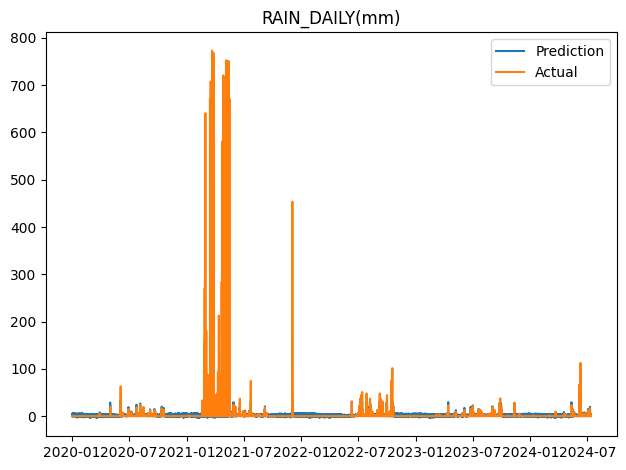

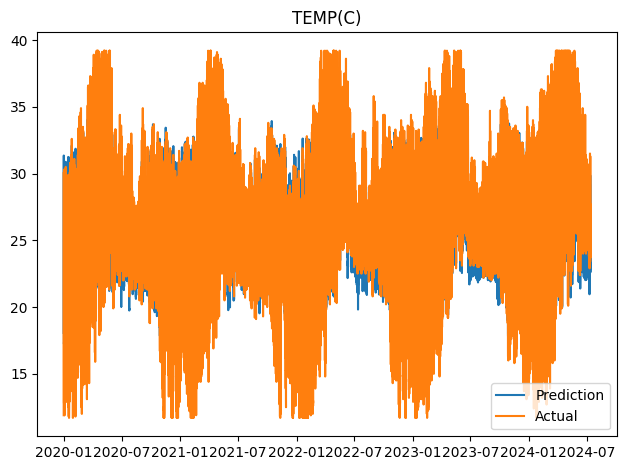

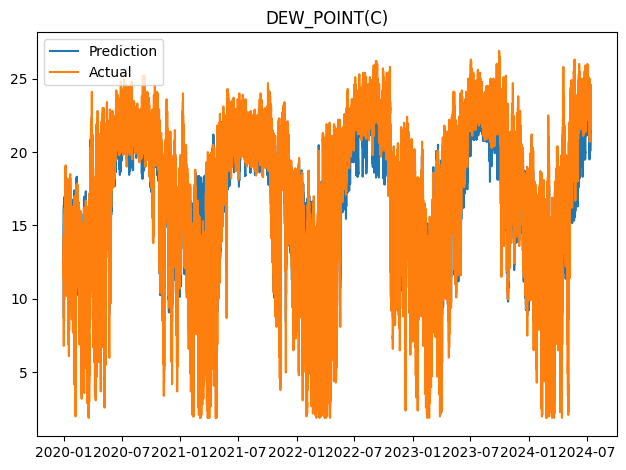

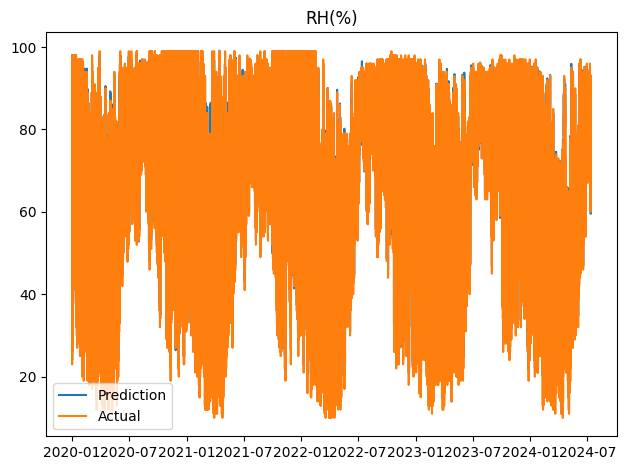

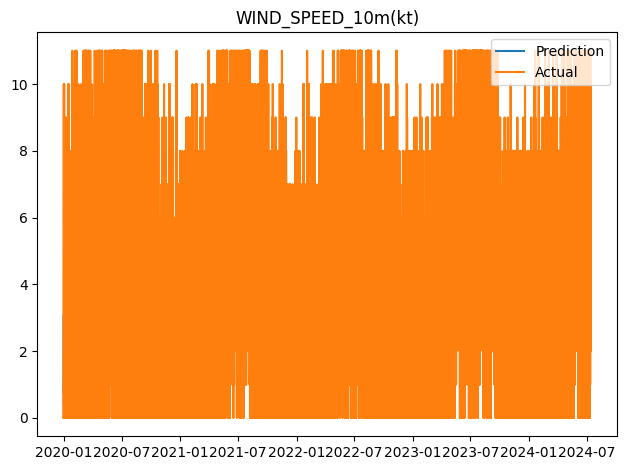

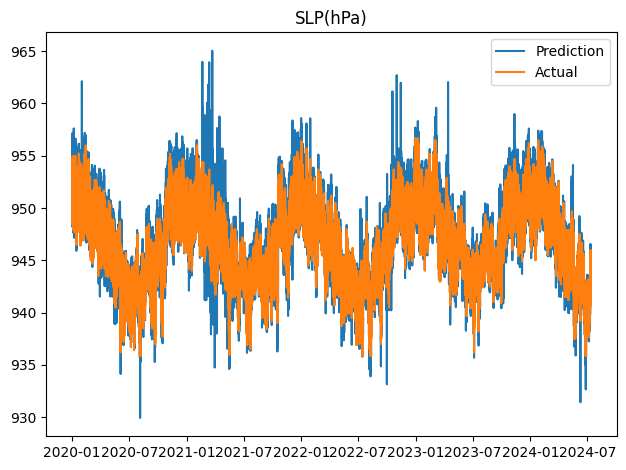

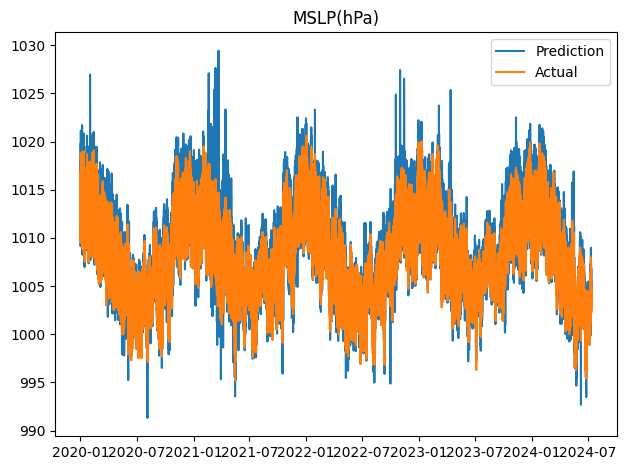

In [24]:
for col in predictions.columns:
    plt.plot(predictions[col], label='Prediction')
    plt.plot(df[col], label='Actual')
    plt.legend()
    plt.title(f'{col}')
    plt.tight_layout()
    plt.show()

In [25]:
last_sequence = X[-seq_length:]
last_sequence = last_sequence.reshape((1, seq_length, X.shape[1]))
next_row_prediction = model.predict(last_sequence, batch_size=20)
next_row_prediction

1/1 [==============================] - 1s 1s/step


array([[   2.4135914,   24.387844 ,   21.75885  ,   83.99004  ,
           3.8155062,  943.58905  , 1005.4695   ]], dtype=float32)

In [ ]:
last_timestamp = df['Timestamp'].iloc[-1]
end_date = last_timestamp + datetime.timedelta(days=7)
start_date = last_timestamp + datetime.timedelta(minutes=15)

forecast_df = pd.DataFrame(columns=df.columns)
forecast_df['Timestamp'] = pd.to_datetime(pd.date_range(start=start_date, end=end_date, freq="15min"))

day = 24*60*60
year = (365.2425)*day
seconds = (forecast_df['Timestamp'] - forecast_df['Timestamp'][0]).dt.total_seconds()
forecast_df['Day sin'] = np.sin(seconds * (2 * np.pi / day))
forecast_df['Day cos'] = np.cos(seconds * (2 * np.pi / day))
forecast_df['Year sin'] = np.sin(seconds * (2 * np.pi / year))
forecast_df['Year cos'] = np.cos(seconds * (2 * np.pi / year))
forecast_df

,Timestamp,RAIN_DAILY(mm),TEMP(C),DEW_POINT(C),RH(%),WIND_SPEED_10m(kt),SLP(hPa),MSLP(hPa),Day sin,Day cos,Year sin,Year cos
0,2024-07-12 05:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000
1,2024-07-12 05:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065403,0.997859,0.000179,1.000000
2,2024-07-12 05:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.130526,0.991445,0.000358,1.000000
3,2024-07-12 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.195090,0.980785,0.000538,1.000000
4,2024-07-12 06:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258819,0.965926,0.000717,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
667,2024-07-19 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.321439,0.946930,0.119239,0.992866
668,2024-07-19 04:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.258819,0.965926,0.119417,0.992844
669,2024-07-19 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.195090,0.980785,0.119595,0.992823
670,2024-07-19 04:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.130526,0.991445,0.119773,0.992801


In [ ]:
def predict_next_row(model, last_sequence):
    last_sequence = last_sequence.reshape((1, seq_length, X.shape[1]))
    next_row_prediction = model.predict(last_sequence)
    return next_row_prediction[0]

In [ ]:
ext_df = pd.concat([df, forecast_df], axis=0)
last_index = df[df['Timestamp'] == last_timestamp].index[0]
ext_df

,Timestamp,RAIN_DAILY(mm),TEMP(C),DEW_POINT(C),RH(%),WIND_SPEED_10m(kt),SLP(hPa),MSLP(hPa),Day sin,Day cos,Year sin,Year cos
0,2020-01-01 02:15:00,0.0,11.9,11.5,98.0,0.0,950.7,1015.9,0.000000,1.000000,0.000000,1.000000
1,2020-01-01 02:30:00,0.0,12.4,12.0,98.0,0.0,951.0,1016.1,0.065403,0.997859,0.000179,1.000000
2,2020-01-01 02:45:00,0.0,13.7,13.3,98.0,1.0,951.2,1016.1,0.130526,0.991445,0.000358,1.000000
3,2020-01-01 03:00:00,0.0,15.0,14.3,96.0,1.0,951.5,1016.1,0.195090,0.980785,0.000538,1.000000
4,2020-01-01 03:15:00,0.0,16.7,13.8,83.0,1.0,951.9,1016.1,0.258819,0.965926,0.000717,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
667,2024-07-19 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.321439,0.946930,0.119239,0.992866
668,2024-07-19 04:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.258819,0.965926,0.119417,0.992844
669,2024-07-19 04:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.195090,0.980785,0.119595,0.992823
670,2024-07-19 04:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.130526,0.991445,0.119773,0.992801


In [ ]:
next_row = predict_next_row(model, last_sequence)
next_row

1/1 [==============================] - 0s 27ms/step


array([   3.0641108,   22.533049 ,   18.721107 ,   71.597305 ,
          2.4049788,  942.694    , 1005.0651   ], dtype=float32)

In [ ]:
for i in range(forecast_df.shape[0]):
    last_sequence = X[-seq_length:]
    last_sequence = last_sequence.reshape((1, seq_length, X.shape[1]))
    next_row_prediction = model.predict(last_sequence)
    forecast_df.iloc[i, 1:8] = next_row_prediction

    #t = np.concatenate([next_row_prediction.reshape(1), forecast_df.iloc[i, 8:].values])

    df1 = pd.concat([df, forecast_df[:i]])
    X = df1.values

In [ ]:
forecast_df

,Timestamp,RAIN_DAILY(mm),TEMP(C),DEW_POINT(C),RH(%),WIND_SPEED_10m(kt),SLP(hPa),MSLP(hPa)
0,2024-07-12 05:00:00,2.6766834,24.685349,17.436037,68.688774,3.0423472,939.0234,1000.56244
1,2024-07-12 05:15:00,2.6180418,24.738073,17.379042,68.18038,3.1601892,933.40814,994.63184
2,2024-07-12 05:30:00,2.6591446,24.697405,17.37373,67.34361,3.342675,921.9292,982.39624
3,2024-07-12 05:45:00,2.6601112,24.593887,17.308113,66.26539,3.5126417,907.60614,967.12823
4,2024-07-12 06:00:00,2.5361083,24.11947,16.952696,64.624306,3.4758842,886.0525,944.108
...,...,...,...,...,...,...,...,...
668,2024-07-19 04:00:00,0.5129742,8.588455,6.097663,21.666876,1.4192758,300.1867,318.79004
669,2024-07-19 04:15:00,0.5129742,8.588455,6.097663,21.666876,1.4192758,300.1867,318.79004
670,2024-07-19 04:30:00,0.5129742,8.588455,6.097663,21.666876,1.4192758,300.1867,318.79004
671,2024-07-19 04:45:00,0.5129742,8.588455,6.097663,21.666876,1.4192758,300.1867,318.79004


In [ ]:
forecast_df.to_csv("D:\Anshul\Code\IMD\Data\Shivajinagar\ML Forecast.csv")